In [2]:
import pandas as pd
import re
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from navec import Navec
path = r"C:\Users\User\Documents\github\He_who_laughs_last\data\embedded\navec.tar"
navec = Navec.load(path)

In [27]:
def preprocess_read_russia(jk):
    res = []
    for i in tqdm(jk):
        clean_text = re.sub(r'(?:(?!\u0301)[\W\d_])+', ' ', i)
        res.append(clean_text.split())
    return res

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

def pad_data(data,target,mode='embed'):
    if mode !='embed':
        for i in tqdm(range(len(data))):
            if(len(data[i]) == target):
                continue
            elif(len(data[i]) < target):
                while len(data[i]) != target:
                    data[i].append(0)
            elif(len(data[i]) > target):
                data[i] = data[i][:target]
        return data
    else:
        for i in tqdm(range(len(data))):
            if(len(data[i]) == target):
                continue
            elif(len(data[i]) < target):
                while len(data[i]) != target:
                    data[i].append(navec['<pad>'])
            elif(len(data[i]) > target):
                data[i] = data[i][:target]
        return data

def embed_navec(data):
    embedded = []
    for i in tqdm(range(len(data))):
        emb = []
        for word in data[i]:
            if(navec.get(word) is None):
                emb.append(navec['<unk>'])
            else:
                emb.append(navec[word])
        embedded.append(emb)
    return embedded

<Axes: ylabel='Frequency'>

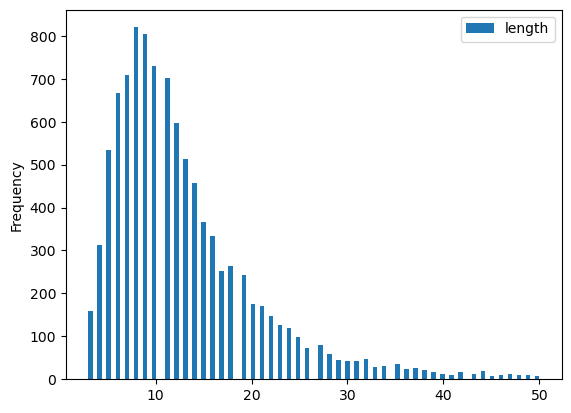

In [16]:
jokes_raw[jokes_raw.length <=50].sample(n=10000,random_state=42).plot(kind='hist',bins=100)

## Больше 90% анекдотов имеют длину <= 40, имеет смысл отсечь по 30 или 40 датасет
### Как реализую сейчас - размер одного образца датасета других текстов на 30
#### UPD. Что было сделано:
- Использован эмбединг Navec для шуток и новостных статей
- Решено пока эмбедить по id слов, так как иначе - супер много память ( > 25 гб для статей )
- В итоге размерность векторов = 30
- Размерность выборок: 250к - анекдоты, 200к - статьи

In [61]:
print(jokes_raw['length'].quantile(0.95))


31.0


# Подготовка датасета к использованию классическими моделями
### *Идея - с помощью PCA уменьшить размерность каждого образца с 9000 координат до ~ 120 координат на каждый образец*

In [41]:
from sklearn.decomposition import PCA 


In [ ]:
def preprocess_compact(data, target_len ):
    num_of_c = target_len//len(data[0])
    pca = PCA(n_components=num_of_c)
    res = []
    for i in 